# Import Library

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import os
import graphviz

In [29]:
!pip install kaggle

In [30]:
!pip install graphviz

In [31]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kaylaaisya","key":"b92c1f6e772ea6b87b19c608e7b8c4b6"}'}

# Import Dataset From Kaggle

In [32]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alperenmyung/social-media-advertisement-performance --unzip

# List files in the current directory
print("Files in the current directory:")
print(os.listdir())

# Assuming the CSV files are in the current directory after unzipping
csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]

dataframes = {}
for csv_file in csv_files:
  df_name = os.path.splitext(csv_file)[0]
  dataframes[df_name] = pd.read_csv(csv_file)
  display(dataframes[df_name].head())

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/alperenmyung/social-media-advertisement-performance
License(s): CC0-1.0
  0% 0.00/15.4M [00:00<?, ?B/s]
100% 15.4M/15.4M [00:00<00:00, 632MB/s]
Files in the current directory:
['.config', 'campaigns.csv', 'ad_events.csv', 'users.csv', 'ads.csv', 'overall_funnel_chart.png', 'kaggle.json', 'ad_campaign_db.sqlite', 'kaggle (1).json', 'click_to_purchase_by_ad_type.json', 'funnel_flowchart.png', 'sample_data']


,campaign_id,name,start_date,end_date,duration_days,total_budget
0,1,Campaign_1_Launch,2025-05-25,2025-07-23,59,24021.32
1,2,Campaign_2_Launch,2025-04-16,2025-07-07,82,79342.41
2,3,Campaign_3_Winter,2025-05-04,2025-06-29,56,14343.25
3,4,Campaign_4_Summer,2025-06-04,2025-08-08,65,45326.60
4,5,Campaign_5_Launch,2025-07-11,2025-08-28,48,68376.69


,event_id,ad_id,user_id,timestamp,day_of_week,time_of_day,event_type
0,1,197,2359b,2025-07-26 00:19:56,Saturday,Night,Like
1,2,51,f9c67,2025-06-15 08:28:07,Sunday,Morning,Share
2,3,46,5b868,2025-06-27 00:40:02,Friday,Night,Impression
3,4,166,3d440,2025-06-05 19:20:45,Thursday,Evening,Impression
4,5,52,68f1a,2025-07-22 08:30:29,Tuesday,Morning,Impression


,user_id,user_gender,user_age,age_group,country,location,interests
0,a2474,Female,24,18-24,United Kingdom,New Mariomouth,"fitness, health"
1,141e5,Male,21,18-24,Germany,Danielsfort,"food, fitness, lifestyle"
2,34db0,Male,27,25-34,Australia,Vincentchester,"fashion, news"
3,20d08,Female,28,25-34,India,Lisaport,"health, news, finance"
4,9e830,Male,28,25-34,United States,Brownmouth,"health, photography, lifestyle"


,ad_id,campaign_id,ad_platform,ad_type,target_gender,target_age_group,target_interests
0,1,28,Facebook,Video,Female,35-44,"art, technology"
1,2,33,Facebook,Stories,All,25-34,"travel, photography"
2,3,20,Instagram,Carousel,All,25-34,technology
3,4,28,Facebook,Stories,Female,25-34,news
4,5,24,Instagram,Image,Female,25-34,news


# Funnel Analysis

## Load Dataset

In [33]:
df_events = pd.read_csv("ad_events.csv")
df_ads = pd.read_csv("ads.csv")
df_campaigns = pd.read_csv("campaigns.csv")
df_users = pd.read_csv("users.csv")

## Building Funnel Stages

In [34]:
funnel_stages = ['Impression', 'Click', 'Purchase']
funnel_users = {}

for stage in funnel_stages:
  stage_events = df_events[df_events['event_type'] == stage]
  unique_users_at_stage = set(stage_events['user_id'].unique())
  funnel_users[stage] = unique_users_at_stage

# Apply waterfall logic for unique users
users_impression = funnel_users['Impression']
users_click = users_impression.intersection(funnel_users['Click'])
users_purchase = users_click.intersection(funnel_users['Purchase'])

funnel_data = {
          'Stage': funnel_stages,
          'Users': [len(users_impression), len(users_click), len(users_purchase)]
}
df_funnel = pd.DataFrame(funnel_data).sort_values(by='Users', ascending=False)
print("\nOverall Funnel:")
print(df_funnel.to_string())


Overall Funnel:
        Stage  Users
0  Impression   9950
1       Click   9772
2    Purchase   1806


## Calculate Conversion Rates

In [35]:
df_funnel['Prev_Stage_Users'] = df_funnel['Users'].shift(1)
df_funnel['Stage-to-Stage CR (%)'] = (df_funnel['Users'] / df_funnel['Prev_Stage_Users']) * 100
df_funnel['Stage-to-Stage CR (%)'] = df_funnel['Stage-to-Stage CR (%)'].fillna(100)
df_funnel['Drop-off (Users)'] = (df_funnel['Prev_Stage_Users'] - df_funnel['Users']).fillna(0).astype(int)
df_funnel['Drop-off (%)'] = (df_funnel['Drop-off (Users)'] / df_funnel['Prev_Stage_Users']) * 100
df_funnel['Drop-off (%)'] = df_funnel['Drop-off (%)'].fillna(0)

overall_cr = (len(users_purchase) / len(users_impression)) * 100 if len(users_impression) > 0 else 0

print("\nFunnel with Conversion Rates and Drop-offs:")
print(df_funnel[['Stage', 'Users', 'Stage-to-Stage CR (%)', 'Drop-off (Users)', 'Drop-off (%)']].to_string())
print(f"\nOverall Conversion Rate (Purchase / Impression): {overall_cr:.4f}%")


Funnel with Conversion Rates and Drop-offs:
        Stage  Users  Stage-to-Stage CR (%)  Drop-off (Users)  Drop-off (%)
0  Impression   9950             100.000000                 0      0.000000
1       Click   9772              98.211055               178      1.788945
2    Purchase   1806              18.481375              7966     81.518625

Overall Conversion Rate (Purchase / Impression): 18.1508%


## Build Funnel Chart

/tmp/ipython-input-447869530.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


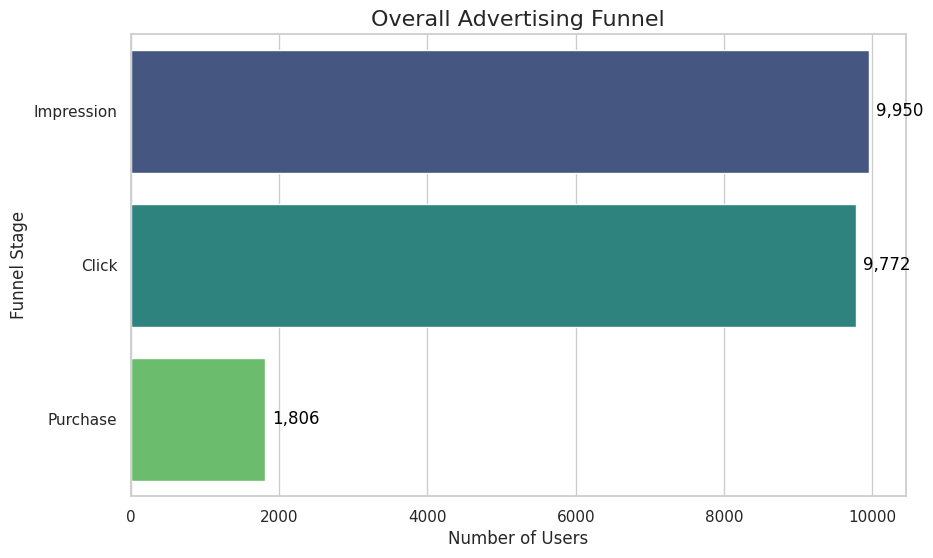

In [36]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", n_colors=len(df_funnel))
bar_plot = sns.barplot(
          x='Users',
          y='Stage',
          data=df_funnel,
          palette=colors,
          order=df_funnel['Stage']
)

for index, row in df_funnel.iterrows():
  bar_plot.text(row['Users'] + (0.01 * df_funnel['Users'].max()), index, f"{row['Users']:,}", color='black', ha="left", va="center")

plt.title('Overall Advertising Funnel', fontsize=16)
plt.xlabel('Number of Users', fontsize=12)
plt.ylabel('Funnel Stage', fontsize=12)

chart_filename = 'overall_funnel_chart.png'
plt.savefig(chart_filename, bbox_inches='tight')

## Build Funnel Flowchart

In [37]:
dot = graphviz.Digraph(comment='Ad Funnel Flowchart')
dot.attr(rankdir='LR') # Left-to-Right layout

# Add nodes
for index, row in df_funnel.iterrows():
  dot.node(
  row['Stage'],
  f"{row['Stage']}\n{row['Users']:,} Users",
  shape='box',
  style='filled',
  color='skyblue'
          )

# Add edges with conversion and drop-off info
for i in range(len(df_funnel) - 1):
  row_current = df_funnel.iloc[i]
  row_next = df_funnel.iloc[i+1]

  cr = row_next['Stage-to-Stage CR (%)']
  drop_users = row_next['Drop-off (Users)']
  drop_pct = row_next['Drop-off (%)']

  dot.edge(
  row_current['Stage'],
  row_next['Stage'],
  label=f" CR: {cr:.2f}%\nDrop: {drop_users:,} ({drop_pct:.2f}%) "
            )

dot.render('funnel_flowchart', format='png', cleanup=True)

'funnel_flowchart.png'

## Merge Dataset

In [38]:
df_merged = pd.merge(df_events, df_ads, on='ad_id', how='left')
df_merged = pd.merge(df_merged, df_campaigns, on='campaign_id', how='left')
df_merged = pd.merge(df_merged, df_users, on='user_id', how='left')

## Segment Analysis

In [39]:
segments_to_analyze = ['ad_platform', 'ad_type', 'country', 'age_group', 'user_gender']

for segment_by in segments_to_analyze:
    print(f"\n--- Funnel by {segment_by.replace('_', ' ').title()} ---")

    grouped_segments = df_merged.groupby(segment_by)
    funnel_results = {}

    for segment_name, segment_data in grouped_segments:
        users_impression = set(segment_data[segment_data['event_type'] == 'Impression']['user_id'].unique())
        users_click = set(segment_data[segment_data['event_type'] == 'Click']['user_id'].unique())
        users_purchase = set(segment_data[segment_data['event_type'] == 'Purchase']['user_id'].unique())

        users_click_waterfall = users_impression.intersection(users_click)
        users_purchase_waterfall = users_click_waterfall.intersection(users_purchase)

        n_impression = len(users_impression)
        n_click = len(users_click_waterfall)
        n_purchase = len(users_purchase_waterfall)

        imp_to_click_cr = (n_click / n_impression) * 100 if n_impression > 0 else 0
        click_to_purchase_cr = (n_purchase / n_click) * 100 if n_click > 0 else 0
        overall_cr = (n_purchase / n_impression) * 100 if n_impression > 0 else 0

        funnel_results[segment_name] = {
            'Impressions': n_impression,
            'Clicks': n_click,
            'Purchases': n_purchase,
            'Imp_to_Click_CR (%)': imp_to_click_cr,
            'Click_to_Purchase_CR (%)': click_to_purchase_cr,
            'Overall_CR (%)': overall_cr
        }

    df_result = pd.DataFrame.from_dict(funnel_results, orient='index')
    df_result = df_result.sort_values(by='Purchases', ascending=False)
    print(df_result.to_string())



--- Funnel by Ad Platform ---
           Impressions  Clicks  Purchases  Imp_to_Click_CR (%)  Click_to_Purchase_CR (%)  Overall_CR (%)
Facebook          9950    9156       1146            92.020101                 12.516383       11.517588
Instagram         9950    7633        521            76.713568                  6.825626        5.236181

--- Funnel by Ad Type ---
          Impressions  Clicks  Purchases  Imp_to_Click_CR (%)  Click_to_Purchase_CR (%)  Overall_CR (%)
Stories          9950    7179        468            72.150754                  6.519014        4.703518
Carousel         9949    6371        329            64.036587                  5.164024        3.306865
Image            9948    6483        295            65.168878                  4.550362        2.965420
Video            9908    4853        162            48.980622                  3.338141        1.635042

--- Funnel by Country ---
                Impressions  Clicks  Purchases  Imp_to_Click_CR (%)  Click_to_Pu